# Softmax **Function**

In [ ]:
import torch
from torch import nn


import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as accuracy_fn


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Import CIFAR 100 Dataset using the datasets model of torchvision

In [ ]:
train_data = datasets.CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Checking the shape of the image
print(train_data[0][0].shape)

# Checking size of the data
print(len(train_data), len(test_data))

# Checking different categories in the data
print(train_data.classes)
print(train_data.class_to_idx)

torch.Size([3, 32, 32])
50000 10000
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',

Plotting first 16 images of the training data



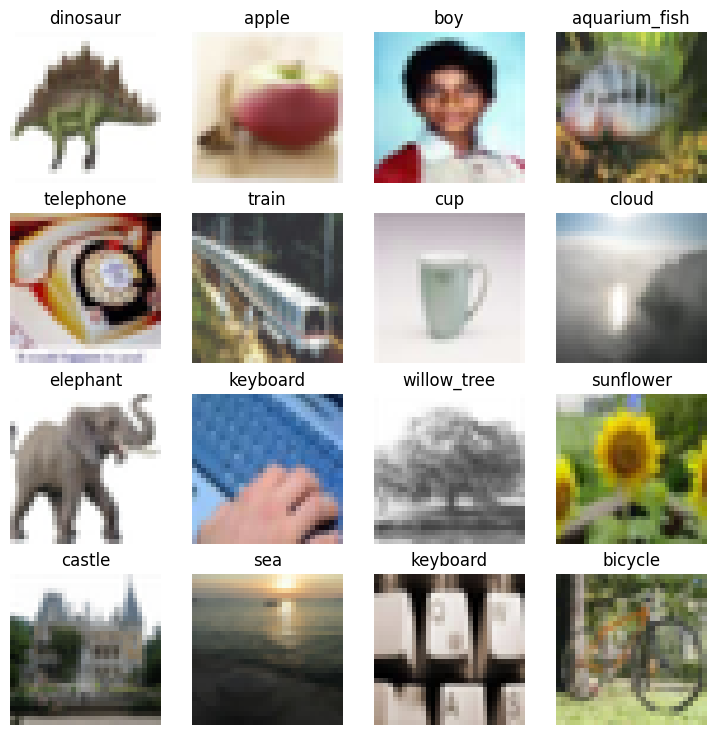

In [ ]:
fig = plt.figure(figsize= (9,9))
rows, cols = 4,4
for i in range(1, rows*cols + 1):
  img, label = train_data[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(train_data.classes[label])
  plt.axis(False)

As we are gonna use batch gradient descent for training the data we are gonna gonna divide the training data into batches of 32 using pytorch inbuilt module of DataLoader.

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f3114919d00>, <torch.utils.data.dataloader.DataLoader object at 0x7f3116dfc610>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


Building the Convolutional Neural Network here , specifically I am using the Tiny VGG architecture.



In [ ]:
class CIFAR_Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, 
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10,
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=640, ## Found using relation between output and input layers shape
                      out_features=100)
        )
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x
model_1 = CIFAR_Decoder().to(device)

Setting up accuracy_fn, loss_fn, optimizer

In [ ]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
activator = nn.Softmax(dim=1)

Setting up the timer

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start:float, end:float):
  total_time = end - start
  print(f"Train time is: {total_time:.3f} seconds")
  return total_time

Creating the training and testing loop on data

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,activator(y_pred).argmax(dim=1)
                                 ) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,activator(test_pred).argmax(dim=1)
                ) # Go from logits -> pred labels
            
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")
        

In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_1 = timer()
from tqdm.auto import tqdm
# Train and test model 
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn_1,
        optimizer=optimizer_1,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn_1,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.60554 | Train accuracy: 0.01
Test loss: 4.60502 | Test accuracy: 0.01

Epoch: 1
---------
Train loss: 4.60472 | Train accuracy: 0.01
Test loss: 4.60355 | Test accuracy: 0.02

Epoch: 2
---------
Train loss: 4.58535 | Train accuracy: 0.02
Test loss: 4.50001 | Test accuracy: 0.03

Epoch: 3
---------
Train loss: 4.27070 | Train accuracy: 0.06
Test loss: 4.15222 | Test accuracy: 0.07

Epoch: 4
---------
Train loss: 4.05047 | Train accuracy: 0.09
Test loss: 3.97374 | Test accuracy: 0.09

Epoch: 5
---------
Train loss: 3.81520 | Train accuracy: 0.13
Test loss: 3.82802 | Test accuracy: 0.13

Epoch: 6
---------
Train loss: 3.61909 | Train accuracy: 0.17
Test loss: 3.72120 | Test accuracy: 0.16

Epoch: 7
---------
Train loss: 3.44228 | Train accuracy: 0.20
Test loss: 3.45667 | Test accuracy: 0.20

Epoch: 8
---------
Train loss: 3.30011 | Train accuracy: 0.23
Test loss: 3.37055 | Test accuracy: 0.21

Epoch: 9
---------
Train loss: 3.18901 | Train accuracy: 0.24
Te

In [ ]:
model_1.load_state_dict(torch.load(f="/content/03_pytorch_computer_vision_model_1 (1).pth"))

# Send model to GPU
model_1 = model_1.to(device)

# **Gumbel_Softmax**

In [ ]:
def gumbel_softmax_sample(logits):
    disturbance = -torch.log(-torch.log(torch.rand(logits.size()) + 1e-20) + 1e-20)
    y = logits + disturbance

    return torch.softmax(y, dim=-1)


In [ ]:
class Gumbel_CIFAR_Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, 
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10,
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=640, ## Found using relation between output and input layers shape
                      out_features=100)
        )
    
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    x = gumbel_softmax_sample(x)
    return x
model_2 = Gumbel_CIFAR_Decoder().to(device)

In [ ]:
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr =0.01)
loss_fn_2 = nn.NLLLoss()

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               loss_lst,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device) 
        
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(torch.log(y_pred),y)
        
        train_loss += loss
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1)
                                 ) # Go from logits -> pred labels
        if batch%500 == 0:
          print(f'{batch}, {loss}')
          loss_lst.append(loss)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(torch.log(test_pred),y)
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1)
                ) # Go from logits -> pred labels
            
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")

In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()
from tqdm.auto import tqdm
# Train and test model 
epochs = 10
losses = []
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn_2,
        optimizer=optimizer_2,
        accuracy_fn=accuracy_fn,
        loss_lst = losses,
        device=device
    )
    
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn_2,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           )

In [ ]:
model_2.load_state_dict(torch.load(f="/content/03_gumbel_weights (2).pth"))

# Send model to GPU
model_2 = model_2.to(device)

# **Hierarchial_Softmax**

In [ ]:
class H_Softmax(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList([nn.Linear(in_features=100, out_features=1) for i in range(255)])
    self.init_weights()

  def init_weights(self):
    for layer in self.layers:
      torch.nn.init.xavier_uniform_(layer.weight)
      if layer.bias is not None:
        layer.bias.data.fill_(0.0)


  def forward(self, y:torch.Tensor, x:torch.Tensor):
    y = y.tolist()
    probs_tensor = torch.ones((len(y), 1))
    for k in y:
      value_to_change = int(k)
      idx = y.index(k)
      hidden_x = x[idx,:]
      k=k+127
      for i in range(7):
        if k%2 == 0:
          probs_tensor[idx, :]*= torch.sigmoid((self.layers[int((k-1)/2)](hidden_x))).squeeze()
        else:
          probs_tensor[idx, :]*=torch.sigmoid((self.layers[int((k-1)/2)](-hidden_x))).squeeze()
        k = int((k-1)/2)
    
    return probs_tensor

In [ ]:
class H_Softmax_CIFAR_Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, 
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10,
                  out_channels = 10,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=640, ## Found using relation between output and input layers shape
                      out_features=100)
      
        )
    self.activation = H_Softmax()
  def forward(self,y, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    hidden = x
    x = self.activation(y,x)
    return x, hidden
model_3 = H_Softmax_CIFAR_Decoder().to(device)

In [ ]:
optimizer_3 = torch.optim.SGD(params=model_3.parameters(), lr=0.01)
loss_fn_3 = nn.NLLLoss()

In [ ]:
def predict(layers, position, p:torch.Tensor,x:torch.Tensor):
  if int(p[:,position]) != -1:
    return p[:,position]
  else:
    if position%2 == 0:
      p[:,position] = predict(layers, int((position-1)/2), p, x)*torch.sigmoid(layers[int((position-1)/2)](x))
    else:
      p[:,position] = predict(layers, int((position-1)/2), p, x)*torch.sigmoid(layers[int((position-1)/2)](-x))
    return p[:,position]

In [ ]:
def train_step(model1: torch.nn.Module,
               #model2: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               #optimizer_tree:torch.optim.Optimizer,
               accuracy_fn,
               loss_lst,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
      
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred, hidden_x = model1(y,X)
        
        # 2. Calculate loss
        loss = loss_fn(torch.log(y_pred),torch.zeros(len(y), dtype=torch.long))
        
        
        if(batch % 500) == 0:
          loss_lst.append(loss.item())
          #print(type(loss))
          print(f"{batch}, {loss}")
        
          probs_final = torch.ones((hidden_x.shape[0], 100))
          for i in range(hidden_x.shape[0]):
            hidden_x1 = hidden_x[i,:]
            probs = torch.ones((1,255))*-1
            probs[:,0] = 1
            for k in range(127,227):
              predict(model.activation.layers, k, probs, hidden_x1)
            
            probs_final[i,:] = probs[:, 127:227]
        
          accuracy = accuracy_fn(y,probs_final.argmax(dim=1))
          print(f"Accuracy is {accuracy}")
        train_loss = train_loss + loss
        # Go from logits -> pred labels
        # 3. Optimizer zero grad
        ## Have to do train accuracy
        
        optimizer.zero_grad()
        
        # 4. Loss backward
        
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model1: torch.nn.Module,
              #model2: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred,test_hidden = model1(y,X)            
            # 2. Calculate loss and accuracy
            test_loss = test_loss + loss_fn(torch.log(test_pred),torch.zeros(len(y), dtype=torch.long))
            probs_final = torch.ones((test_hidden.shape[0], 100))
            for i in range(test_hidden.shape[0]):
              test_hidden_x1 = test_hidden[i,:]
              probs = torch.ones((1,255))*-1
              probs[:,0] = 1
              for k in range(127,227):
                predict(model.activation.layers, k, probs, test_hidden_x1)
              probs_final[i,:] = probs[:, 127:227]
            accuracy = accuracy_fn(y,probs_final.argmax(dim=1))
            test_acc+=accuracy

        # Go from logits -> pred labels  
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")


In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()
from tqdm.auto import tqdm
losses = []
# Train and test model 
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model1=model_3,
        loss_fn=loss_fn_3,
        optimizer=optimizer_3,
        accuracy_fn=accuracy_fn,
        loss_lst=losses,
        device=device
    )
    
    test_step(data_loader=test_dataloader,
        model1=model_3,
        loss_fn=loss_fn_3,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           )

In [ ]:
model_3.load_state_dict(torch.load(f="/content/H_Softmax_parameters"))

# Send model to GPU
model_3 = model_3.to(device)

# Evaluation **Metrics**

In [ ]:
#find predicted values of model_1
y_test = []
y_pred_1 = []
y_pred_2 = []
y_pred_3 = []
k1 = []
k2 = []
k3 = []

with torch.inference_mode():
  for X,y in test_dataloader:
      X, y = X.to(device), y.to(device)
      y_test += y.tolist()
      test_pred_1 = model_1(X)
      test_pred_2 = model_2(X)
      k1 += activator(test_pred_1).argmax(dim=1)
      k2 += test_pred_2.argmax(dim=1)
      test_pred_3,test_hidden = model_3(y,X)
      probs_final = torch.ones((test_hidden.shape[0], 100))
      for i in range(test_hidden.shape[0]):
        test_hidden_x1 = test_hidden[i,:]
        probs = torch.ones((1,255))*-1
        probs[:,0] = 1
        for k in range(127,227):
          predict(model_3.activation.layers, k, probs, test_hidden_x1)
        probs_final[i,:] = probs[:, 127:227]
      k3 += probs_final.argmax(dim=1)

y_pred_1 += [i.item() for i in k1]
y_pred_2 += [i.item() for i in k2]
y_pred_3 += [i.item() for i in k3]

Confusion_Matrices

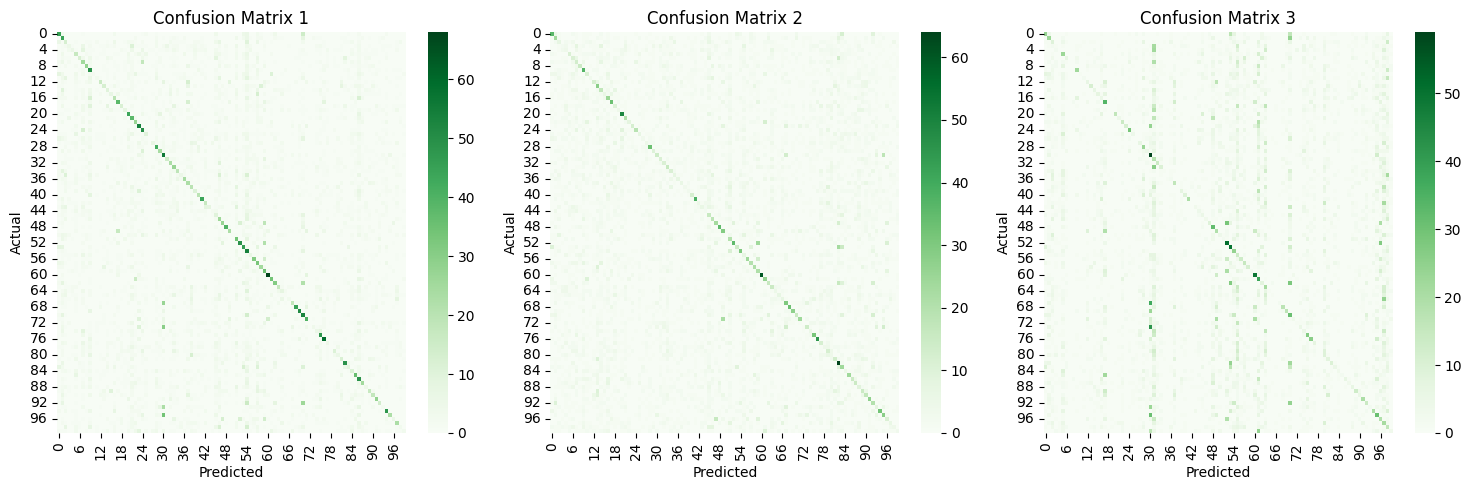

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate three sample confusion matrices
cm1 = confusion_matrix(y_test, y_pred_1, labels=[i for i in range(100)])
cm2 = confusion_matrix(y_test, y_pred_2, labels=[i for i in range(100)])
cm3 = confusion_matrix(y_test, y_pred_3, labels=[i for i in range(100)])

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first confusion matrix on the first subplot
sns.heatmap(cm1, cmap="Greens", ax=axs[0])
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")
axs[0].set_title("Confusion Matrix 1")

# Plot the second confusion matrix on the second subplot
sns.heatmap(cm2, cmap="Greens", ax=axs[1])
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")
axs[1].set_title("Confusion Matrix 2")

# Plot the third confusion matrix on the third subplot
sns.heatmap(cm3, cmap="Greens", ax=axs[2])
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("Actual")
axs[2].set_title("Confusion Matrix 3")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


**Accuracy, Precision, Recall**, **F1_score**

In [ ]:
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute the performance metrics for each model
acc1 = accuracy_score(y_test, y_pred_1)
acc2 = accuracy_score(y_test, y_pred_2)
acc3 = accuracy_score(y_test, y_pred_3)

prec1 = precision_score(y_test, y_pred_1, average='macro')
prec2 = precision_score(y_test, y_pred_2, average='macro')
prec3 = precision_score(y_test, y_pred_3, average='macro')

rec1 = recall_score(y_test, y_pred_1, average='macro')
rec2 = recall_score(y_test, y_pred_2, average='macro')
rec3 = recall_score(y_test, y_pred_3, average='macro')

f1_1 = f1_score(y_test, y_pred_1, average='macro')
f1_2 = f1_score(y_test, y_pred_2, average='macro')
f1_3 = f1_score(y_test, y_pred_3, average='macro')

# Create a table with the performance metrics
headers = ["Metric", "Model 1", "Model 2", "Model 3"]
table = [["Accuracy", acc1, acc2, acc3],
         ["Precision", prec1, prec2, prec3],
         ["Recall", rec1, rec2, rec3],
         ["F1 score", f1_1, f1_2, f1_3]]

# Print the table
print(tabulate(table, headers=headers))


Metric       Model 1    Model 2    Model 3
---------  ---------  ---------  ---------
Accuracy    0.2314     0.1671     0.1183
Precision   0.237453   0.173658   0.147382
Recall      0.2314     0.1671     0.1183
F1 score    0.212231   0.163595   0.102985


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Comparing Performances**

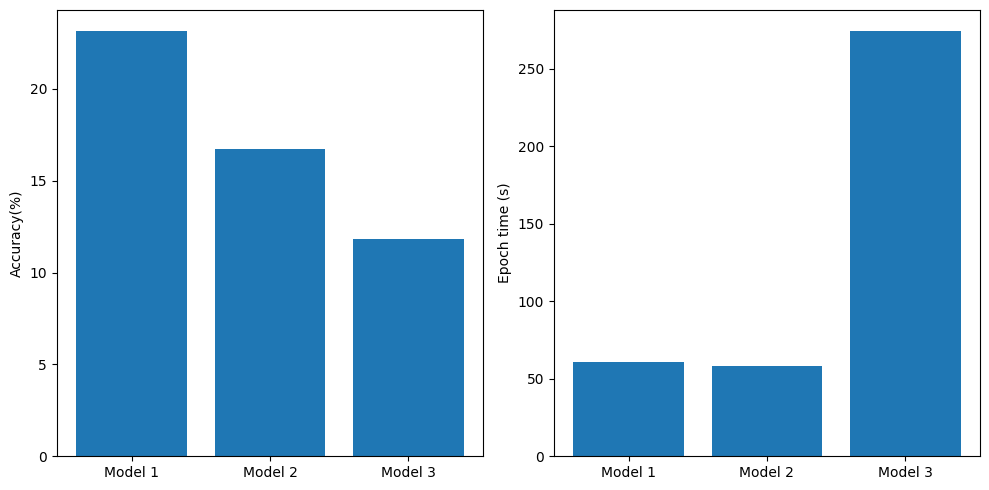

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy and epoch time of each model
accuracy = [23.14, 16.71, 11.83]
epoch_time = [61.13, 58.39, 274.26]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(range(3), accuracy)
axs[0].set_xticks(range(3))
axs[0].set_xticklabels(['Model 1', 'Model 2', 'Model 3'])
axs[0].set_ylabel('Accuracy(%)')

axs[1].bar(range(3), epoch_time)
axs[1].set_xticks(range(3))
axs[1].set_xticklabels(['Model 1', 'Model 2', 'Model 3'])
axs[1].set_ylabel('Epoch time (s)')

plt.tight_layout()
plt.show()
